# Plagiarism Detection, Feature Engineering

In this project, we're building a plagiarism detector that examines an answer text file and performs binary classification; labeling that file as either plagiarized or not, depending on how similar that text file is to a provided, source text. 

In this notebook we:

* Clean and pre-process the data.
* Define features for comparing the similarity of an answer text and a source text, and extract similarity features.
* Select "good" features, by analyzing the correlations between different features.
* Create train/test `.csv` files that hold the relevant features and class labels for train/test data points.

In the _next_ notebook, Notebook 3, we'll use the features and `.csv` files you create in _this_ notebook to train a binary classification model in a SageMaker notebook instance.

The similarity features will be following the advice outline in [this paper](https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c412841_developing-a-corpus-of-plagiarised-short-answers/developing-a-corpus-of-plagiarised-short-answers.pdf), which should help us build a robust plagiarism detector.

---

## Read in the Data

The cell below, when uncommented, will download the necessary, project data and extract the files into the folder `data/`.

This data is a slightly modified version of a dataset created by Paul Clough (Information Studies) and Mark Stevenson (Computer Science), at the University of Sheffield. You can read all about the data collection and corpus, at [their university webpage](https://ir.shef.ac.uk/cloughie/resources/plagiarism_corpus.html). 

> **Citation for data**: Clough, P. and Stevenson, M. Developing A Corpus of Plagiarised Short Answers, Language Resources and Evaluation: Special Issue on Plagiarism and Authorship Analysis, In Press. [Download]

In [7]:
# NOTE:
# you only need to run this cell if you have not yet downloaded the data

# !wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
# !unzip data

In [62]:
# import libraries
import pandas as pd
import numpy as np
import helpers 
import os
import re
from sklearn.model_selection import train_test_split
import helpers
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This plagiarism dataset is made of multiple text files; each of these files has characteristics that are is summarized in a `.csv` file named `file_information.csv`, which we can read in using `pandas`.

In [9]:
csv_file = 'data/file_information.csv'
plagiarism_df = pd.read_csv(csv_file)

# print out the first few rows of data info
plagiarism_df.head()

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non


## Types of Plagiarism

Each text file is associated with one **Task** (task A-E) and one **Category** of plagiarism, which you can see in the above DataFrame.

###  Tasks, A-E

Each text file contains an answer to one short question; these questions are labeled as tasks A-E. For example, Task A asks the question: "What is inheritance in object oriented programming?"

### Categories of plagiarism 

Each text file has an associated plagiarism label/category:

**1. Plagiarized categories: `cut`, `light`, and `heavy`.**
* These categories represent different levels of plagiarized answer texts. `cut` answers copy directly from a source text, `light` answers are based on the source text but include some light rephrasing, and `heavy` answers are based on the source text, but *heavily* rephrased (and will likely be the most challenging kind of plagiarism to detect).
     
**2. Non-plagiarized category: `non`.** 
* `non` indicates that an answer is not plagiarized; the Wikipedia source text is not used to create this answer.
    
**3. Special, source text category: `orig`.**
* This is a specific category for the original, Wikipedia source text. We will use these files only for comparison purposes.

---
## Pre-Process the Data

In the next few cells, we'll be creating a new DataFrame of desired information about all of the files in the `data/` directory. This will prepare the data for feature extraction and for training a binary, plagiarism classifier, as well as a multi-class classifier later down the line.

We'll convert the `Category` column into into numerical values. Additionally, our goal is to create a binary classifier and so we'll need a binary class label that indicates whether an answer text is plagiarized (1) or not (0). We'll return to the multi-class label later.

In [10]:
plagiarism_df.head(3)

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light


### Test cells

Below are a couple of test cells. The first is an informal test where you can check that your code is working as expected by calling your function and printing out the returned result.

The **second** cell below is a more rigorous test cell. The goal of a cell like this is to ensure that your code is working as expected, and to form any variables that might be used in _later_ tests/code, in this case, the data frame, `transformed_df`.

> The cells in this notebook should be run in chronological order (the order they appear in the notebook). This is especially important for test cells.

Often, later cells rely on the functions, imports, or variables defined in earlier cells. For example, some tests rely on previous tests to work.

These tests do not test all cases, but they are a great way to check that you are on the right track!

In [11]:
# informal testing, print out the results of a called function
# create new `transformed_df`
transformed_df = helpers.numerical_dataframe(csv_file ='data/file_information.csv')

# check work
# check that all categories of plagiarism have a class label = 1
transformed_df.head(10)

,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0
5,g0pB_taska.txt,a,0,0
6,g0pB_taskb.txt,b,0,0
7,g0pB_taskc.txt,c,3,1
8,g0pB_taskd.txt,d,2,1
9,g0pB_taske.txt,e,1,1


In [12]:
# test cell that creates `transformed_df`, if tests are passed
# importing tests
import problem_unittests as tests

# test numerical_dataframe function
tests.test_numerical_df(helpers.numerical_dataframe)

# if above test is passed, create NEW `transformed_df`
transformed_df = helpers.numerical_dataframe(csv_file ='data/file_information.csv')

# check work
print('\nExample data: ')
transformed_df.head()

Tests Passed!

Example data: 


,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0


## Text Processing & Splitting Data

At it's heart, this task is a comparison text; one that looks at a given answer and a source text, compares them and predicts whether an answer has plagiarized from the source. To effectively do this comparison, and train a classifier we'll need to do a few more things: pre-process all of our text data and prepare the text files (in this case, the 95 answer files and 5 original source files) to be easily compared, and split our data into a `train` and `test` set that can be used to train a classifier and evaluate it, respectively. 

The next two cells need not be changed; they add two additional columns to the `transformed_df`:

1. A `Text` column; this holds all the lowercase text for a `File`, with extraneous punctuation removed.
2. A `Datatype` column; this is a string value `train`, `test`, or `orig` that labels a data point as part of our train or test set

The details of how these additional columns are created can be found in the `helpers.py` file in the project directory. 


In [64]:

# create a text column 
text_df = helpers.create_text_column(transformed_df)
text_df.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model (also called term vecto...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [16]:
# after running the cell above
# check out the processed text for a single file, by row index
row_idx = 0 # feel free to change this index

sample_text = text_df.iloc[0]['Text']

print('Sample processed text:\n\n', sample_text)

Sample processed text:

 inheritance is a basic concept of object oriented programming where the basic idea is to create new classes that add extra detail to existing classes this is done by allowing the new classes to reuse the methods and variables of the existing classes and new methods and classes are added to specialise the new class inheritance models the is kind of relationship between entities (or objects) for example postgraduates and undergraduates are both kinds of student this kind of relationship can be visualised as a tree structure where student would be the more general root node and both postgraduate and undergraduate would be more specialised extensions of the student node (or the child nodes) in this relationship student would be known as the superclass or parent class whereas  postgraduate would be known as the subclass or child class because the postgraduate class extends the student class  inheritance can occur on several layers where if visualised would display a

## Split data into training and test sets

The next cell will add a `Datatype` column to a given DataFrame to indicate if the record is: 
* `train` - Training data, for model training.
* `test` - Testing data, for model evaluation.
* `orig` - The task's original answer from wikipedia.

### Stratified sampling

The given code uses a helpers.py function that implements [stratified random sampling](https://en.wikipedia.org/wiki/Stratified_sampling) to randomly split data by task & plagiarism amount. Stratified sampling ensures that we get training and test data that is fairly evenly distributed across task & plagiarism combinations. Approximately 26% of the data is held out for testing and 74% of the data is used for training.

The function **train_test_dataframe** takes in a DataFrame that it assumes has `Task` and `Category` columns, and, returns a modified frame that indicates which `Datatype` (train, test, or orig) a file falls into. This sampling will change slightly based on a passed in *random_seed*. Due to a small sample size, this stratified random sampling will provide more stable results for a binary plagiarism classifier. Stability here is smaller *variance* in the accuracy of classifier, given a random seed.

In [17]:
csv_file

'data/file_information.csv'

In [20]:
random_seed = 1 # can change; set for reproducibility

# create new df with Datatype (train, test, orig) column
# pass in `text_df` from above to create a complete dataframe, with all the information you need
complete_df = helpers.train_test_dataframe(text_df, random_seed=random_seed)

# check results
complete_df.tail(8)

,File,Task,Category,Class,Text,Datatype
92,g4pE_taskc.txt,c,3,1,the definition of term depends on the applicat...,train
93,g4pE_taskd.txt,d,0,0,bayes theorem or bayes rule or something cal...,train
94,g4pE_taske.txt,e,0,0,dynamic programming is a method for efficient...,test
95,orig_taska.txt,a,-1,-1,in object oriented programming inheritance is ...,orig
96,orig_taskb.txt,b,-1,-1,pagerank is a link analysis algorithm used by ...,orig
97,orig_taskc.txt,c,-1,-1,vector space model (or term vector model) is a...,orig
98,orig_taskd.txt,d,-1,-1,in probability theory bayes theorem (often cal...,orig
99,orig_taske.txt,e,-1,-1,in mathematics and computer science dynamic pr...,orig


In [21]:
complete_df.loc[complete_df['File']=='g4pD_taskd.txt']['Text'].values

array(['bayes theorem is a simple mathematical formula used for calculating conditional probabilities bayes theorem is a theorem of probability theory originally stated by the reverend thomas bayes it figures prominently in subjectivist or bayesian approaches to epistemology statistics and inductive logic it can be seen as a way of understanding how the probability that a theory is true is affected by a new piece of evidence it has been used in a wide variety of contexts ranging from marine biology to the development of bayesian spam blockers for email systems in the philosophy of science it has been used to try to clarify the relationship between theory and evidence many insights in the philosophy of science involving confirmation falsification the relation between science and pseudosience and other topics can be made more precise and sometimes extended or corrected by using bayes theorem subjectivists who maintain that rational belief is governed by the laws of probability lean heavi

# Determining Plagiarism
---


## Similarity Features 

We'll be computing **similarity features** that measure how similar a given answer text is as compared to the original wikipedia source text (for a specific task, a-e). The similarity features you will use are informed by [this paper on plagiarism detection](https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c412841_developing-a-corpus-of-plagiarised-short-answers/developing-a-corpus-of-plagiarised-short-answers.pdf). 
> In this paper, researchers created features called **containment** and **longest common subsequence**. 

## Feature Engineering

Let's talk a bit more about the features we want to include in a plagiarism detection model and how to calculate such features. In the following explanations, I'll refer to a submitted text file as a **Student Answer Text (A)** and the original, wikipedia source file (that we want to compare that answer to) as the **Wikipedia Source Text (S)**.

### Containment

Your first task will be to create **containment features**. To understand containment, let's first revisit a definition of [n-grams](https://en.wikipedia.org/wiki/N-gram). An *n-gram* is a sequential word grouping. For example, in a line like "bayes rule gives us a way to combine prior knowledge with new information," a 1-gram is just one word, like "bayes." A 2-gram might be "bayes rule" and a 3-gram might be "combine prior knowledge."

> Containment is defined as the **intersection** of the n-gram word count of the Wikipedia Source Text (S) with the n-gram word count of the Student  Answer Text (S) *divided* by the n-gram word count of the Student Answer Text.

$$ \frac{\sum{count(\text{ngram}_{A}) \cap count(\text{ngram}_{S})}}{\sum{count(\text{ngram}_{A})}} $$

If the two texts have no n-grams in common, the containment will be 0, but if _all_ their n-grams intersect then the containment will be 1. Intuitively, you can see how having longer n-gram's in common, might be an indication of cut-and-paste plagiarism. In this project, it will be up to you to decide on the appropriate `n` or several `n`'s to use in your final model.


### Containment calculation

The general steps to complete this function are as follows:
1. From *all* of the text files in a given `df`, create an array of n-gram counts; it is suggested that you use a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for this purpose.
2. Get the processed answer and source texts for the given `answer_filename`.
3. Calculate the containment between an answer and source text according to the following equation.

    >$$ \frac{\sum{count(\text{ngram}_{A}) \cap count(\text{ngram}_{S})}}{\sum{count(\text{ngram}_{A})}} $$
    
4. Return that containment value.


In [22]:
type(complete_df.Task[0])

str

In [25]:
# have to create a column with the actual, original answer, so that the student answer and source text 
# are equally accessible on the same row of the dataframe
complete_df['ANSWER'] = ''
# for x in ['a','b','c', 'd','e']:
answerA = complete_df.loc[((complete_df['Category']==-1) & (complete_df['Task'] == 'a'))]['Text'].values[0]
answerB = complete_df.loc[((complete_df['Category']==-1) & (complete_df['Task'] == 'b'))]['Text'].values[0]
answerC = complete_df.loc[((complete_df['Category']==-1) & (complete_df['Task'] == 'c'))]['Text'].values[0]
answerD = complete_df.loc[((complete_df['Category']==-1) & (complete_df['Task'] == 'd'))]['Text'].values[0]
answerE = complete_df.loc[((complete_df['Category']==-1) & (complete_df['Task'] == 'e'))]['Text'].values[0]

In [24]:
answerB

'pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents such as the world wide web with the purpose of measuring its relative importance within the set the algorithm may be applied to any collection of entities with reciprocal quotations and references the numerical weight that it assigns to any given element e is also called the pagerank of e and denoted by pr(e) the name pagerank is a trademark of google and the pagerank process has been patented (u s patent 6 285 999 ) however the patent is assigned to stanford university and not to google google has exclusive license rights on the patent from stanford university the university received 1 8 million shares in google in exchange for use of the patent the shares were sold in 2005 for 336 million google describes pagerank pagerank relies on the uniquely democratic nature of the web by using its vast link structure as an indicato

In [26]:
complete_df.head()

,File,Task,Category,Class,Text,Datatype,ANSWER
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train,
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,test,
2,g0pA_taskc.txt,c,2,1,the vector space model (also called term vecto...,train,
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train,
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train,


In [27]:
complete_df.loc[complete_df['Task'] == 'a' , ['ANSWER']] = answerA
complete_df.loc[complete_df['Task'] == 'b' , ['ANSWER']] = answerB
complete_df.loc[complete_df['Task'] == 'c' , ['ANSWER']] = answerC
complete_df.loc[complete_df['Task'] == 'd' , ['ANSWER']] = answerD
complete_df.loc[complete_df['Task'] == 'e' , ['ANSWER']] = answerE
complete_df.head(20)

,File,Task,Category,Class,Text,Datatype,ANSWER
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train,in object oriented programming inheritance is ...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,test,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model (also called term vecto...,train,vector space model (or term vector model) is a...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train,in probability theory bayes theorem (often cal...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train,in mathematics and computer science dynamic pr...
5,g0pB_taska.txt,a,0,0,inheritance is a basic concept in object orien...,train,in object oriented programming inheritance is ...
6,g0pB_taskb.txt,b,0,0,pagerank (pr) refers to both the concept and t...,train,pagerank is a link analysis algorithm used by ...
7,g0pB_taskc.txt,c,3,1,vector space model is an algebraic model for r...,test,vector space model (or term vector model) is a...
8,g0pB_taskd.txt,d,2,1,bayes theorem relates the conditional and marg...,train,in probability theory bayes theorem (often cal...
9,g0pB_taske.txt,e,1,1,dynamic programming is a method for solving ma...,test,in mathematics and computer science dynamic pr...


In [28]:
test = complete_df[:5]
test

,File,Task,Category,Class,Text,Datatype,ANSWER
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train,in object oriented programming inheritance is ...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,test,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model (also called term vecto...,train,vector space model (or term vector model) is a...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train,in probability theory bayes theorem (often cal...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train,in mathematics and computer science dynamic pr...


### Test cells

The cell below iterates through the first few files, and calculates the original category _and_ containment values for a specified n and file.

>If implemented correctly, the non-plagiarized have low or close to 0 containment values and that plagiarized examples have higher containment values, closer to 1.

Note what happens when you change the value of n. I recommend applying your code to multiple files and comparing the resultant containment values. You should see that the highest containment values correspond to files with the highest category (`cut`) of plagiarism level.

In [30]:
# select a value for n
n = 3

# indices for first few files
test_indices = range(0,5)

# iterate through files and calculate containment
category_vals = []
containment_vals = []
for i in test_indices:
    # get level of plagiarism for a given file index
    category_vals.append(complete_df.loc[i, 'Category'])
    # calculate containment for given file and n
    filename = complete_df.loc[i, 'File']
    c = helpers.calculate_containment(complete_df, n, filename)
    containment_vals.append(c)

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print(str(n)+'-gram containment values: \n', containment_vals)

Original category values: 
 [0, 3, 2, 1, 0]

3-gram containment values: 
 [0.009345794392523364, 0.9641025641025641, 0.6136363636363636, 0.15675675675675677, 0.031746031746031744]


In [32]:
# run this test cell
# test containment calculation
# params: complete_df from before, and containment function
tests.test_containment(complete_df, helpers.calculate_containment)

Tests Passed!


Containment features can be calculated for any new input data and require the presence of the new input student answer as well as the answer text (wikipedia source text). Unlike other feature engineering such as scaling which vary depending on the train-test split, containment will only affected by each observational unit of data (each student response) and its wikipedia answer text. 

---
## Longest Common Subsequence

Containment a good way to find overlap in word usage between two documents; it may help identify cases of cut-and-paste as well as paraphrased levels of plagiarism. Since plagiarism is a fairly complex task with varying levels, it's often useful to include other measures of similarity. The paper also discusses a feature called **longest common subsequence**.

> The longest common subsequence is the longest string of words (or letters) that are *the same* between the Wikipedia Source Text (S) and the Student Answer Text (A). This value is also normalized by dividing by the total number of words (or letters) in the  Student Answer Text. 



It may be helpful to think of this in a concrete example. A Longest Common Subsequence (LCS) problem may look as follows:
* Given two texts: text A (answer text) of length n, and string S (original source text) of length m. Our goal is to produce their longest common subsequence of words: the longest sequence of words that appear left-to-right in both texts (though the words don't have to be in continuous order).
* Consider:
    * A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
    * S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"

* In this case, we can see that the start of each sentence of fairly similar, having overlap in the sequence of words, "pagerank is a link analysis algorithm used by" before diverging slightly. Then we **continue moving left -to-right along both texts** until we see the next common sequence; in this case it is only one word, "google". Next we find "that" and "a" and finally the same ending "to each element of a hyperlinked set of documents".
* Below, is a clear visual of how these sequences were found, sequentially, in each text.

<img src='notebook_ims/common_subseq_words.png' width=50% />

* Now, those words appear in left-to-right order in each document, sequentially, and even though there are some words in between, we count this as the longest common subsequence between the two texts. 
* If I count up each word that I found in common I get the value 20. **So, LCS has length 20**. 
* Next, to normalize this value, divide by the total length of the student answer; in this example that length is only 27. **So, the function `lcs_norm_word` should return the value `20/27` or about `0.7408`.**

In this way, LCS is a great indicator of cut-and-paste plagiarism or if someone has referenced the same source text multiple times in an answer.

### LCS, dynamic programming

If you read through the scenario above, you can see that this algorithm depends on looking at two texts and comparing them word by word. You can solve this problem in multiple ways. First, it may be useful to `.split()` each text into lists of comma separated words to compare. Then, you can iterate through each word in the texts and compare them, adding to your value for LCS as you go. 

The recommended method for implementing an efficient LCS algorithm is using a matrix and dynamic programming. **Dynamic programming** is all about breaking a larger problem into a smaller set of subproblems, and building up a complete result without having to repeat any subproblems. 

This approach assumes that you can split up a large LCS task into a combination of smaller LCS tasks. Let's look at a simple example that compares letters:

* A = "ABCD"
* S = "BD"

We can see right away that the longest subsequence of _letters_ here is 2 (B and D are in sequence in both strings). And we can calculate this by looking at relationships between each letter in the two strings, A and S.

Here, I have a matrix with the letters of A on top and the letters of S on the left side:

<img src='notebook_ims/matrix_1.png' width=40% />

This starts out as a matrix that has as many columns and rows as letters in the strings S and O **+1** additional row and column, filled with zeros on the top and left sides. So, in this case, instead of a 2x4 matrix it is a 3x5.

Now, we can fill this matrix up by breaking it into smaller LCS problems. For example, let's first look at the shortest substrings: the starting letter of A and S. We'll first ask, what is the Longest Common Subsequence between these two letters "A" and "B"? 

**Here, the answer is zero and we fill in the corresponding grid cell with that value.**

<img src='notebook_ims/matrix_2.png' width=30% />

Then, we ask the next question, what is the LCS between "AB" and "B"?

**Here, we have a match, and can fill in the appropriate value 1**.

<img src='notebook_ims/matrix_3_match.png' width=25% />

If we continue, we get to a final matrix that looks as follows, with a **2** in the bottom right corner.

<img src='notebook_ims/matrix_6_complete.png' width=25% />

The final LCS will be that value **2** *normalized* by the number of n-grams in A. So, our normalized value is 2/4 = **0.5**.

### The matrix rules

One thing to notice here is that, you can efficiently fill up this matrix one cell at a time. Each grid cell only depends on the values in the grid cells that are directly on top and to the left of it, or on the diagonal/top-left. The rules are as follows:
* Start with a matrix that has one extra row and column of zeros.
* As you traverse your string:
    * If there is a match, fill that grid cell with the value to the top-left of that cell *plus* one. So, in our case, when we found a matching B-B, we added +1 to the value in the top-left of the matching cell, 0.
    * If there is not a match, take the *maximum* value from either directly to the left or the top cell, and carry that value over to the non-match cell.

<img src='notebook_ims/matrix_rules.png' width=50% />

After completely filling the matrix, **the bottom-right cell will hold the non-normalized LCS value**.

This matrix treatment can be applied to a set of words instead of letters. Your function should apply this to the words in two texts and return the normalized LCS value.

In [34]:
from nltk import RegexpTokenizer

### Test cells
In the below cell, we have specified strings A (answer text) and S (original source text). We know that these texts have 20 words in common and the submitted answer is 27 words long, so the normalized, longest common subsequence should be 20/27.


In [65]:
%%time
# Run the test scenario from above
# does your function return the expected value?

A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"

# calculate LCS
lcs = helpers.lcs_norm_word(A, S)
print('LCS = ', lcs)


# expected value test
assert lcs==20/27., "Incorrect LCS value, expected about 0.7408, got "+str(lcs)

print('Test passed!')

LCS =  0.7407407407407407
Test passed!
CPU times: user 1.16 ms, sys: 132 µs, total: 1.3 ms
Wall time: 1.19 ms


This next cell runs a more rigorous test.

In [67]:
%%time
# run test cell
# test lcs implementation
# params: complete_df from before, and lcs_norm_word function
tests.test_lcs(complete_df, helpers.lcs_norm_word)

Tests Passed!
CPU times: user 513 ms, sys: 4.03 ms, total: 517 ms
Wall time: 519 ms


Finally, take a look at a few resultant values for `lcs_norm_word`. Just like before, you should see that higher values correspond to higher levels of plagiarism.

In [68]:
%%time
# test on your own
test_indices = range(5) # look at first few files

category_vals = []
lcs_norm_vals = []
# iterate through first few docs and calculate LCS
for i in test_indices:
    category_vals.append(complete_df.loc[i, 'Category'])
    # get texts to compare
    answer_text = complete_df.loc[i, 'Text'] 
    task = complete_df.loc[i, 'Task']
    # we know that source texts have Class = -1
    orig_rows = complete_df[(complete_df['Class'] == -1)]
    orig_row = orig_rows[(orig_rows['Task'] == task)]
    source_text = orig_row['Text'].values[0]
    
    # calculate lcs
    lcs_val = helpers.lcs_norm_word(answer_text, source_text)
    lcs_norm_vals.append(lcs_val)

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print('Normalized LCS values: \n', lcs_norm_vals)

Original category values: 
 [0, 3, 2, 1, 0]

Normalized LCS values: 
 [0.1917808219178082, 0.8207547169811321, 0.8464912280701754, 0.3160621761658031, 0.24257425742574257]
CPU times: user 445 ms, sys: 3.55 ms, total: 449 ms
Wall time: 450 ms


---
# Create All Features

We're now going to create the multiple features and store those in a DataFrame, `features_df`.

### Creating multiple containment features

This function returns a list of containment features, calculated for a given `n` and for *all* files in a df (assumed to the the `complete_df`).

For our original files, the containment value is set to a special value, -1.

This function gives you the ability to easily create several containment features, of different n-gram lengths, for each of our text files.

### Creating LCS features

Below, your complete `lcs_norm_word` function is used to create a list of LCS features for all the answer files in a given DataFrame (again, this assumes you are passing in the `complete_df`. It assigns a special value for our original, source files, -1.

Create a features DataFrame by selecting an `ngram_range`

The paper suggests calculating the following features: containment *1-gram to 5-gram* and *longest common subsequence*. 

In the below cell **define an n-gram range**; these will be the n's you use to create n-gram containment features. The rest of the feature creation code is provided.

In [89]:
# Define an ngram range
ngram_range = range(1,21)


# The following code may take a minute to run, depending on your ngram_range
features_list = []

# Create features in a features_df
all_features = np.zeros((len(ngram_range)+1, len(complete_df)))

# Calculate features for containment for ngrams in range
i=0
for n in ngram_range:
    column_name = 'c_'+str(n)
    features_list.append(column_name)
    # create containment features
    features = helpers.create_containment_features(complete_df, n)
    all_features[i]=np.squeeze(features)
    i+=1

1-gram containment features created!
2-gram containment features created!
3-gram containment features created!
4-gram containment features created!
5-gram containment features created!
6-gram containment features created!
7-gram containment features created!
8-gram containment features created!
9-gram containment features created!
10-gram containment features created!
11-gram containment features created!
12-gram containment features created!
13-gram containment features created!
14-gram containment features created!
15-gram containment features created!
16-gram containment features created!
17-gram containment features created!
18-gram containment features created!
19-gram containment features created!
20-gram containment features created!


In [90]:
# Calculate features for LCS_Norm Words 
features_list.append('lcs_word')
all_features[i]= np.squeeze(helpers.create_lcs_features(complete_df))

# create a features dataframe
features_df = pd.DataFrame(np.transpose(all_features), columns=features_list)

# Print all features/columns
print()
print('Features: ', features_list)
print()

LCS features created!

Features:  ['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18', 'c_19', 'c_20', 'lcs_word']



In [91]:
# print some results 
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   c_1       100 non-null    float64
 1   c_2       100 non-null    float64
 2   c_3       100 non-null    float64
 3   c_4       100 non-null    float64
 4   c_5       100 non-null    float64
 5   c_6       100 non-null    float64
 6   c_7       100 non-null    float64
 7   c_8       100 non-null    float64
 8   c_9       100 non-null    float64
 9   c_10      100 non-null    float64
 10  c_11      100 non-null    float64
 11  c_12      100 non-null    float64
 12  c_13      100 non-null    float64
 13  c_14      100 non-null    float64
 14  c_15      100 non-null    float64
 15  c_16      100 non-null    float64
 16  c_17      100 non-null    float64
 17  c_18      100 non-null    float64
 18  c_19      100 non-null    float64
 19  c_20      100 non-null    float64
 20  lcs_word  100 non-null    float64

## Correlated Features

We'll inspect the correlation of features across the *entire* dataset to determine which features are ***too*** **highly-correlated** with each other to include both features in a single model. For this analysis, we'll use the *entire* dataset due to the small sample size we have. 

All of our features try to measure the similarity between two texts. Since our features are designed to measure similarity, it is expected that these features will be highly-correlated. Many classification models, for example a Naive Bayes classifier, rely on the assumption that features are *not* highly correlated; highly-correlated features may over-inflate the importance of a single feature. 

So, you'll want to choose your features based on which pairings have the lowest correlation. These correlation values range between 0 and 1; from low to high correlation, and are displayed in a [correlation matrix](https://www.displayr.com/what-is-a-correlation-matrix/), below.

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('Reds')

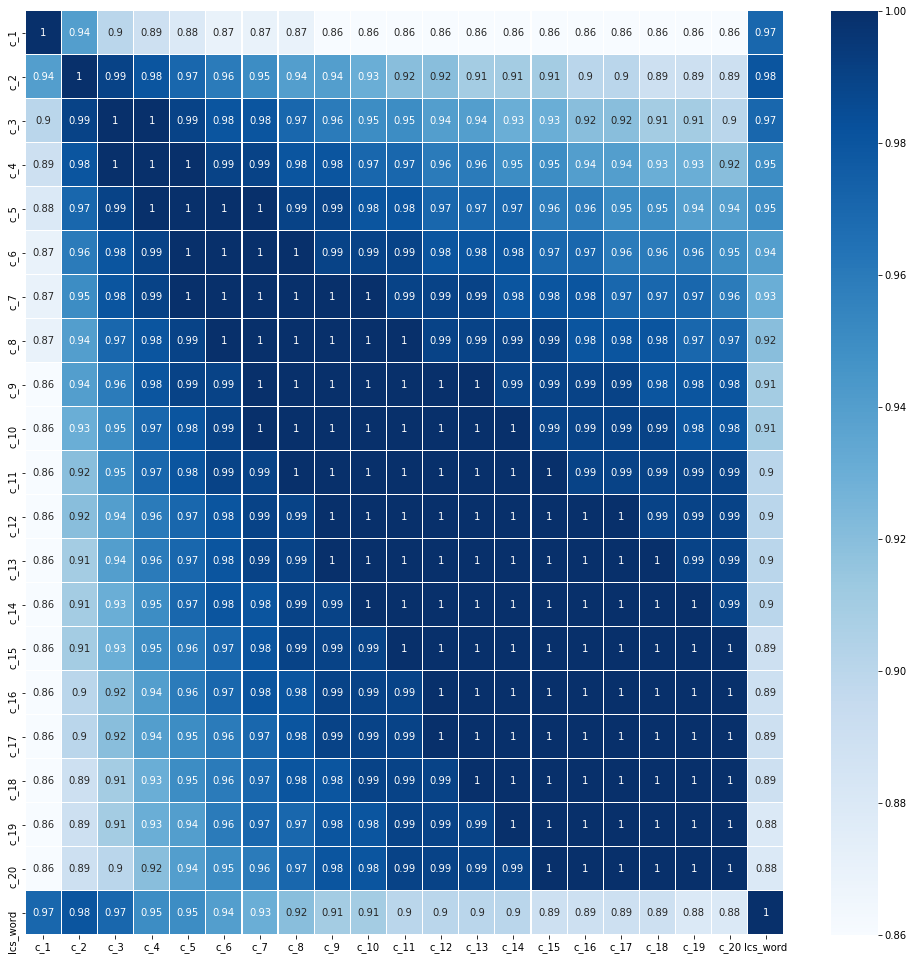

In [77]:

# Create correlation matrix for just Features to determine different models to test
corr_matrix = features_df.corr().abs().round(2)

# display shows all of a dataframe
plt.figure(figsize=(17,17))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', linewidths=0.15);

Taking an arbitrary multicollinearity threshold of 0.98, we are going to include:
- lcs_word
- c_1
- c_3
- c_8
- c_19

However, it's worth questioning if this is the best approach and if a data reduction might not be more worthwhile, using PCA. 

In [49]:
from sklearn.decomposition import PCA


In [53]:
features_df.tail(6)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,lcs_word
94,0.532189,0.163793,0.077922,0.03913,0.017467,0.013158,0.008811,0.004425,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245833
95,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000
96,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000
97,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000
98,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000
99,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000


In [52]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   c_1       100 non-null    float64
 1   c_2       100 non-null    float64
 2   c_3       100 non-null    float64
 3   c_4       100 non-null    float64
 4   c_5       100 non-null    float64
 5   c_6       100 non-null    float64
 6   c_7       100 non-null    float64
 7   c_8       100 non-null    float64
 8   c_9       100 non-null    float64
 9   c_10      100 non-null    float64
 10  c_11      100 non-null    float64
 11  c_12      100 non-null    float64
 12  c_13      100 non-null    float64
 13  c_14      100 non-null    float64
 14  c_15      100 non-null    float64
 15  c_16      100 non-null    float64
 16  c_17      100 non-null    float64
 17  c_18      100 non-null    float64
 18  c_19      100 non-null    float64
 19  c_20      100 non-null    float64
 20  lcs_word  100 non-null    float64

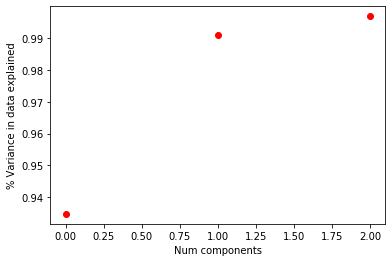

In [55]:
pca_obj = PCA(3, random_state=142)

#not including the five answer rows at the bottom of the dataframe
reduced_features = pca_obj.fit_transform(features_df.iloc[:95])

plt.plot(np.cumsum(pca_obj.explained_variance_ratio_), 'ro')
plt.xlabel('Num components')
plt.ylabel('% Variance in data explained');

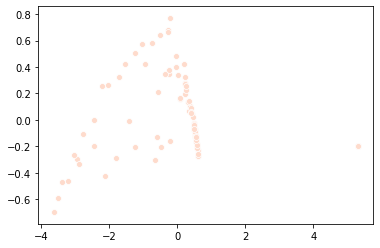

In [56]:
pca_obj = PCA(2, random_state=142)

reduced_features = pca_obj.fit_transform(features_df.dropna())

sns.scatterplot(reduced_features[:,0], reduced_features[:,1], alpha=0.99)

Creating selected train/test data

We've decided on a **cutoff** correlation value, 0.98, to determine which sets of features are *too* highly-correlated to be included in the final training and test data. 

In [57]:
complete_df.tail(10)

,File,Task,Category,Class,Text,Datatype,ANSWER
90,g4pE_taska.txt,a,1,1,object oriented programming is a style of prog...,train,in object oriented programming inheritance is ...
91,g4pE_taskb.txt,b,2,1,pagerankalgorithm is also known as link analys...,train,pagerank is a link analysis algorithm used by ...
92,g4pE_taskc.txt,c,3,1,the definition of term depends on the applicat...,train,vector space model (or term vector model) is a...
93,g4pE_taskd.txt,d,0,0,bayes theorem or bayes rule or something cal...,train,in probability theory bayes theorem (often cal...
94,g4pE_taske.txt,e,0,0,dynamic programming is a method for efficient...,test,in mathematics and computer science dynamic pr...
95,orig_taska.txt,a,-1,-1,in object oriented programming inheritance is ...,orig,in object oriented programming inheritance is ...
96,orig_taskb.txt,b,-1,-1,pagerank is a link analysis algorithm used by ...,orig,pagerank is a link analysis algorithm used by ...
97,orig_taskc.txt,c,-1,-1,vector space model (or term vector model) is a...,orig,vector space model (or term vector model) is a...
98,orig_taskd.txt,d,-1,-1,in probability theory bayes theorem (often cal...,orig,in probability theory bayes theorem (often cal...
99,orig_taske.txt,e,-1,-1,in mathematics and computer science dynamic pr...,orig,in mathematics and computer science dynamic pr...


### Test cells



In [78]:

test_selection = list(features_df)[:2] # first couple columns as a test
# test that the correct train/test data is created
(train_x, train_y), (test_x, test_y) = helpers.train_test_data(complete_df, features_df, test_selection)

# params: generated train/test data
tests.test_data_split(train_x, train_y, test_x, test_y)

Tests Passed!


## Feature selection

If you passed the test above, you can create your own train/test data, below. 

Define a list of features you'd like to include in your final mode, `selected_features`; this is a list of the features names you want to include.

In [80]:
# Select your list of features, this should be column names from features_df
# ex. ['c_1', 'lcs_word']
selected_features = ['c_1', 'c_3','c_8', 'c_19', 'lcs_word']

(train_x, train_y), (test_x, test_y) = helpers.train_test_data(complete_df, features_df, selected_features)

# check that division of samples seems correct
# these should add up to 95 (100 - 5 original files)
print('Training size: ', len(train_x))
print('Test size: ', len(test_x))
print()
print('Training df sample: \n', train_x[:10])

Training size:  70
Test size:  25

Training df sample: 
 [[0.39814815 0.00934579 0.         0.         0.19178082]
 [0.86936937 0.61363636 0.26511628 0.05882353 0.84649123]
 [0.59358289 0.15675676 0.02777778 0.         0.31606218]
 [0.54450262 0.03174603 0.         0.         0.24257426]
 [0.32950192 0.00772201 0.         0.         0.16117216]
 [0.59030837 0.03555556 0.         0.         0.30165289]
 [0.75977654 0.39548023 0.11046512 0.         0.48430493]
 [0.51612903 0.         0.         0.         0.27083333]
 [0.44086022 0.02717391 0.         0.         0.22395833]
 [0.97945205 0.875      0.65467626 0.28125    0.9       ]]



Initially I set an arbitrary threshold for Pearson's correlation, at 0.98. Setting it any lower would have made constrained us to 2-3 features. 
I chose the LCS_norm score as the first feature and then iterated through the common ngram scores, going from lowest to highest. Every time I considered a new feature for the list I compared its correlation with all the other previously selected features: if the one under consideration had a correlation of 0.98 or higher with any of the ones already in my list, I discarded it and carried on. If it didn't, then I added it to the list and then carried on. 

In previous projects I would have set a much lower Pearson's correaltion threshold, around 0.8, but after selecting lcs_norm this would have meant that there were no other features to select. Because of this, I think that decomposing the data into Principal Component would be ideal here (I've included cells above where I do just that), since PCA is ideal for highly inter-correlated continuous data. 

---
## Creating Final Data Files

You'll want to access your train and test data in SageMaker and upload it to S3. In this project, SageMaker will expect the following format for your train/test data:
* Training and test data should be saved in one `.csv` file each, ex `train.csv` and `test.csv`
* These files should have class  labels in the first column and features in the rest of the columns

This format follows the practice, outlined in the [SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html), which reads: "Amazon SageMaker requires that a CSV file doesn't have a header record and that the target variable [class label] is in the first column."


It may be useful to use pandas to merge your features and labels into one DataFrame and then convert that into a csv file. You can make sure to get rid of any incomplete rows, in a DataFrame, by using `dropna`.

### Test cells

Test that your code produces the correct format for a `.csv` file, given some text features and labels.

In [86]:
fake_x = [ [0.39814815, 0.0001, 0.19178082], 
           [0.86936937, 0.44954128, 0.84649123], 
           [0.44086022, 0., 0.22395833] ]

fake_y = [0, 1, 1]

helpers.make_csv(fake_x, fake_y, filename='to_delete.csv', data_dir='test_csv')

# read in and test dimensions
fake_df = pd.read_csv('test_csv/to_delete.csv', header=None)

# check shape
assert fake_df.shape==(3, 4), \
      'The file should have as many rows as data_points and as many columns as features+1 (for indices).'
# check that first column = labels
assert np.all(fake_df.iloc[:,0].values==fake_y), 'First column is not equal to the labels, fake_y.'
print('Tests passed!')

Path created: test_csv/to_delete.csv
Tests passed!


In [87]:
# delete the test csv file, generated above
! rm -rf test_csv

If you've passed the tests above, run the following cell to create `train.csv` and `test.csv` files in a directory that you specify! This will save the data in a local directory. Remember the name of this directory because you will reference it again when uploading this data to S3.

In [88]:
# can change directory, if you want
data_dir = 'plagiarism_data'


helpers.make_csv(train_x, train_y, filename='train.csv', data_dir=data_dir)
helpers.make_csv(test_x, test_y, filename='test.csv', data_dir=data_dir)

Path created: plagiarism_data/train.csv
Path created: plagiarism_data/test.csv


In [93]:
complete_df.head()

,File,Task,Category,Class,Text,Datatype,ANSWER
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train,in object oriented programming inheritance is ...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,test,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model (also called term vecto...,train,vector space model (or term vector model) is a...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train,in probability theory bayes theorem (often cal...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train,in mathematics and computer science dynamic pr...


## Multi-class data

Before moving onto modelling, we'll also create train-test csv files for our multi-class data, since we'd like to be able to refine and improve on our plagiarism detector later down the line. We'll be using the exact same functions as above, just replacing the `target_feature` with 'Category' and storing the data in the 'multiclass_data' directory.

In [94]:
# Select your list of features, this should be column names from features_df
# ex. ['c_1', 'lcs_word']
selected_features = ['c_1', 'c_3','c_8', 'c_19', 'lcs_word']

(train_x, train_y), (test_x, test_y) = helpers.train_test_data(complete_df, features_df, selected_features,
                                                              target_feature='Category')

# check that division of samples seems correct
# these should add up to 95 (100 - 5 original files)
print('Training size: ', len(train_x))
print('Test size: ', len(test_x))
print()
print('Training df sample: \n', train_x[:10])

Training size:  70
Test size:  25

Training df sample: 
 [[0.39814815 0.00934579 0.         0.         0.19178082]
 [0.86936937 0.61363636 0.26511628 0.05882353 0.84649123]
 [0.59358289 0.15675676 0.02777778 0.         0.31606218]
 [0.54450262 0.03174603 0.         0.         0.24257426]
 [0.32950192 0.00772201 0.         0.         0.16117216]
 [0.59030837 0.03555556 0.         0.         0.30165289]
 [0.75977654 0.39548023 0.11046512 0.         0.48430493]
 [0.51612903 0.         0.         0.         0.27083333]
 [0.44086022 0.02717391 0.         0.         0.22395833]
 [0.97945205 0.875      0.65467626 0.28125    0.9       ]]


In [96]:
multiclass_data_dir = 'multiclass_data'

helpers.make_csv(train_x, train_y, filename='multi_train.csv', data_dir=multiclass_data_dir)
helpers.make_csv(test_x, test_y, filename='multi_test.csv', data_dir=multiclass_data_dir)

Path created: multiclass_data/multi_train.csv
Path created: multiclass_data/multi_test.csv


## Up Next

Now that we've finished our feature engineering and created some training and test data, we're are ready to train and deploy a plagiarism classification model. 

The next two notebooks will:
a. utilize SageMaker resources to train and test a model that we design.
b. use standard python libraries to train and test the model.